In [5]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
#Загрузка библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [18]:
#Загрузка данных
df = pd.read_csv('high_popularity_spotify_data.csv')
df.shape

(1686, 29)

In [6]:
# Выбираем числовые признаки и целевую переменную
# track_popularity - целевая для регрессии
features = ['energy', 'tempo', 'danceability', 'loudness', 'liveness', 
            'valence', 'speechiness', 'instrumentalness', 'acousticness', 'duration_ms']
target_reg = 'track_popularity'


In [14]:
# Удаляем пропуски если есть
df.dropna()
df.shape

(1686, 29)

In [19]:
#X — это матрица признаков (входные данные на них мы "гадаем"
#y_reg — это целевая переменная (ответы) это мы "угадываем"
X = df[features].values
y_reg = df[target_reg].values

In [15]:
# Стандартизация данных (Обязательно для градиентного спуска!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Разделение на train/test
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

In [ ]:
# 2. ЛИНЕЙНАЯ РЕГРЕССИЯ
class LinearRegressionSGD:
    def __init__(self, lr=0.01, epochs=100, batch_size=32):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.epochs):
            # Перемешивание данных для mini-batch
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Предсказание
                y_pred = np.dot(X_batch, self.weights) + self.bias
                
                # Градиенты
                error = y_pred - y_batch
                dw = (2 / len(X_batch)) * np.dot(X_batch.T, error)
                db = (2 / len(X_batch)) * np.sum(error)
                
                # Обновление весов
                self.weights -= self.lr * dw
                self.bias -= self.lr * db
                
                # MSE для мониторинга (сумма по батчам усредняется)
                epoch_loss += np.mean(error ** 2)
            
            self.loss_history.append(epoch_loss / (n_samples / self.batch_size))

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


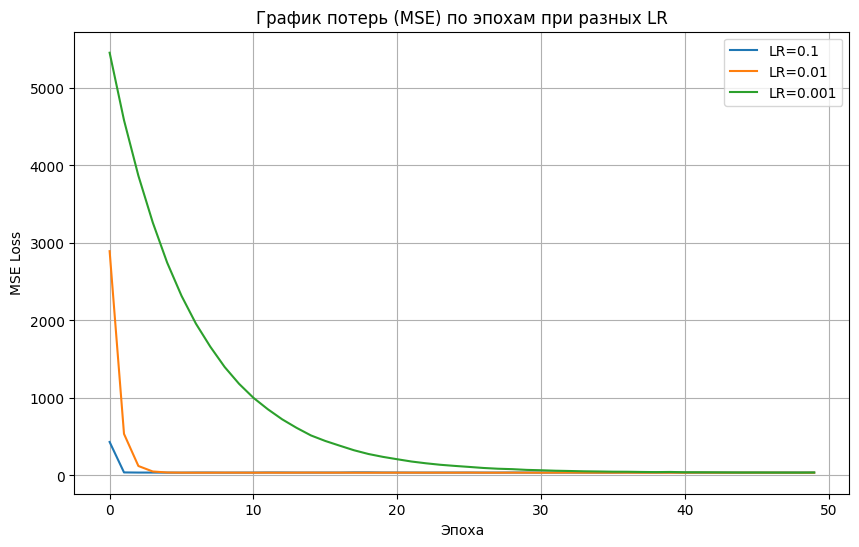

In [20]:
# --- Эксперимент: Влияние Learning Rate ---
plt.figure(figsize=(10, 6))
lrs = [0.1, 0.01, 0.001]
for lr in lrs:
    model = LinearRegressionSGD(lr=lr, epochs=50, batch_size=32)
    model.fit(X_train, y_train_reg)
    plt.plot(model.loss_history, label=f'LR={lr}')

plt.title('График потерь (MSE) по эпохам при разных LR')
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Обучение финальной модели
lin_reg = LinearRegressionSGD(lr=0.01, epochs=100, batch_size=32)
lin_reg.fit(X_train, y_train_reg)

print(f"Коэффициенты линейной регрессии: {lin_reg.weights}")
print(f"Интерсепт: {lin_reg.bias}")


Коэффициенты линейной регрессии: [-0.92719154  0.1465261  -0.18895396  1.08666051 -0.07814352 -0.00948832
 -1.02152504 -0.18374567 -0.33575058 -0.46918501]
Интерсепт: 75.75844700318676


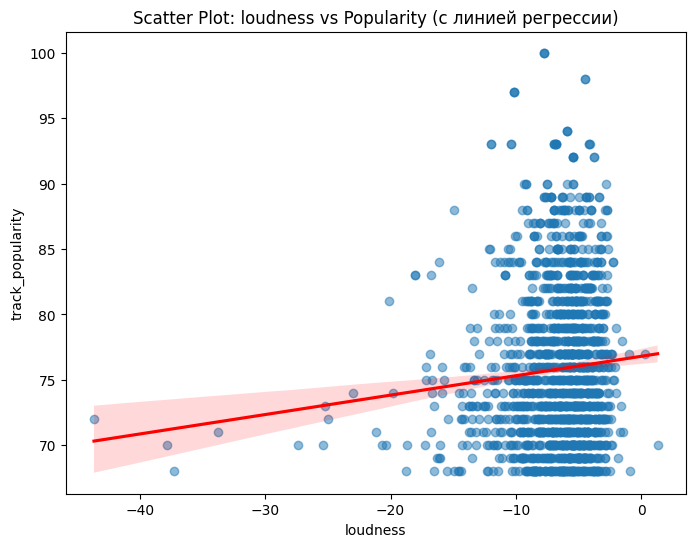

In [30]:
# --- Визуализация: Линия регрессии с доверительным интервалом (для 1 признака) ---
# Для визуализации 2D графика выберем самый коррелирующий признак
feature_to_plot = 'loudness'
feat_idx = features.index(feature_to_plot)

plt.figure(figsize=(8, 6))
# Используем seaborn для автоматического построения линии с доверительным интервалом (CI)
sns.regplot(x=data[feature_to_plot], y=data[target_reg], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title(f'Scatter Plot: {feature_to_plot} vs Popularity (с линией регрессии)')
plt.show()

In [32]:
# 3. КЛАССИФИКАЦИЯ (Логистическая регрессия vs Random Forest)
# Создаем бинарную цель (Высокая популярность > медианы)
median_pop = data[target_reg].median()
y_class = (data[target_reg] > median_pop).astype(int)
print(f"Порог для классификации: {median_pop}")
print(f"Распределение классов:\n{y_class.value_counts()}")

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# --- Логистическая Регрессия (С НУЛЯ) ---
class LogisticRegressionSGD:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)
            
            # Log Loss (с защитой от log(0))
            epsilon = 1e-15
            y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)
            loss = -np.mean(y * np.log(y_pred_clipped) + (1 - y) * np.log(1 - y_pred_clipped))
            self.loss_history.append(loss)
            
            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

Порог для классификации: 75.0
Распределение классов:
track_popularity
0    933
1    753
Name: count, dtype: int64


In [34]:
# Обучение Логистической регрессии
log_reg = LogisticRegressionSGD(lr=0.1, epochs=1000)
log_reg.fit(X_train_c, y_train_c)

In [33]:
# --- Дополнительная модель: Random Forest (Sklearn) ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_c, y_train_c)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [35]:
# 4. СРАВНЕНИЕ И МЕТРИКИ

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_true, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        print(f"ROC AUC:   {roc_auc:.4f}")
        return roc_auc
    return 0

In [36]:
# Оценка
y_pred_log = log_reg.predict(X_test_c)
y_proba_log = log_reg.predict_proba(X_test_c)
auc_log = evaluate_model(y_test_c, y_pred_log, y_proba_log, "Logistic Regression (Manual)")

print("\n")
y_pred_rf = rf_model.predict(X_test_c)
y_proba_rf = rf_model.predict_proba(X_test_c)[:, 1]
auc_rf = evaluate_model(y_test_c, y_pred_rf, y_proba_rf, "Random Forest (Sklearn)")

--- Logistic Regression (Manual) ---
Accuracy: 0.5385
Precision: 0.4820
Recall:    0.4437
F1-Score:  0.4621
Confusion Matrix:
[[115  72]
 [ 84  67]]
ROC AUC:   0.5785


--- Random Forest (Sklearn) ---
Accuracy: 0.6686
Precision: 0.6696
Recall:    0.5099
F1-Score:  0.5789
Confusion Matrix:
[[149  38]
 [ 74  77]]
ROC AUC:   0.7514


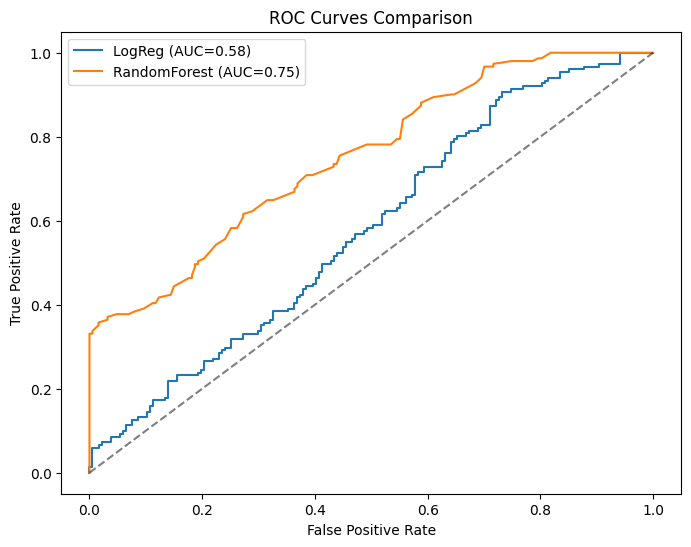

In [37]:
# Визуализация ROC кривых
fpr_log, tpr_log, _ = roc_curve(y_test_c, y_proba_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test_c, y_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'LogReg (AUC={auc_log:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()